![imagen](../img/img3.png)
# Proyecto Machine Learning
- # Bank Customer Churn Detection
- ## **Modelos Machine Learning:** "Churn_processed.csv"

# 1. Librerías necesarias

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import GridSearchCV,train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, precision_score, roc_auc_score, f1_score,roc_curve, precision_recall_curve
from imblearn.under_sampling import RandomUnderSampler
from sklearn.decomposition import PCA

import pickle
import yaml

# 2. Leemos el Dataset Final de "Train_churn_processed.csv"

In [2]:
df_train = pd.read_csv("../data_processed/Train_Churn_processed.csv")
df_train.head()

,Geography,Gender,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Satisfaction Score,Card Type,Point Earned,Age Category,CreditScore Category,Exited
0,0,1,2,0.00,0,1,1,101348.88,2,0,464,2,2,1
1,1,1,1,83807.86,0,0,1,112542.58,3,0,456,2,2,0
2,0,1,8,159660.80,1,1,0,113931.57,3,0,377,2,1,1
3,0,1,1,0.00,0,0,0,93826.63,5,1,350,2,3,0
4,1,1,2,125510.82,0,1,1,79084.10,5,1,425,2,4,0


In [3]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8000 entries, 0 to 7999
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Geography             8000 non-null   int64  
 1   Gender                8000 non-null   int64  
 2   Tenure                8000 non-null   int64  
 3   Balance               8000 non-null   float64
 4   NumOfProducts         8000 non-null   int64  
 5   HasCrCard             8000 non-null   int64  
 6   IsActiveMember        8000 non-null   int64  
 7   EstimatedSalary       8000 non-null   float64
 8   Satisfaction Score    8000 non-null   int64  
 9   Card Type             8000 non-null   int64  
 10  Point Earned          8000 non-null   int64  
 11  Age Category          8000 non-null   int64  
 12  CreditScore Category  8000 non-null   int64  
 13  Exited                8000 non-null   int64  
dtypes: float64(2), int64(12)
memory usage: 875.1 KB


# 3. Separamos **Train** en X e y . Además, lo dividimos en train y test:

## 3.1. X e y de Train

- "X" Estará formada por las **features** : 'Geography', 'Gender', 'Tenure', 'Balance', 'NumOfProducts',
       'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'Satisfaction Score',
       'Card Type', 'Point Earned', 'Age Category', 'CreditScore Category'.
- "y" será nuestra target: `Exited`

In [4]:
X = df_train.drop(columns=["Exited"])
y = df_train["Exited"]

## 3.2. Division de Train en: X_train, X_test, y_train, y_test

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

print("Total features shape:", X.shape)
print("Train features shape:", X_train.shape)
print("Train target shape:", y_train.shape)
print("Test features shape:", X_test.shape)
print("Test target shape:", y_test.shape)

Total features shape: (8000, 13)
Train features shape: (6400, 13)
Train target shape: (6400,)
Test features shape: (1600, 13)
Test target shape: (1600,)


# 4. Desbalance del Traget `Exited`

## 4.1. Visualizamos la situación del desbalance

In [6]:
print("Distribución del Target en y:\n", y.value_counts())
print("-"*35)
print("Distribución del Target en y_train:\n", y_train.value_counts())
print("-"*35)
print("Distribución del Target en y_test:\n", y_test.value_counts())

Distribución del Target en y:
 Exited
0    6353
1    1647
Name: count, dtype: int64
-----------------------------------
Distribución del Target en y_train:
 Exited
0    5067
1    1333
Name: count, dtype: int64
-----------------------------------
Distribución del Target en y_test:
 Exited
0    1286
1     314
Name: count, dtype: int64


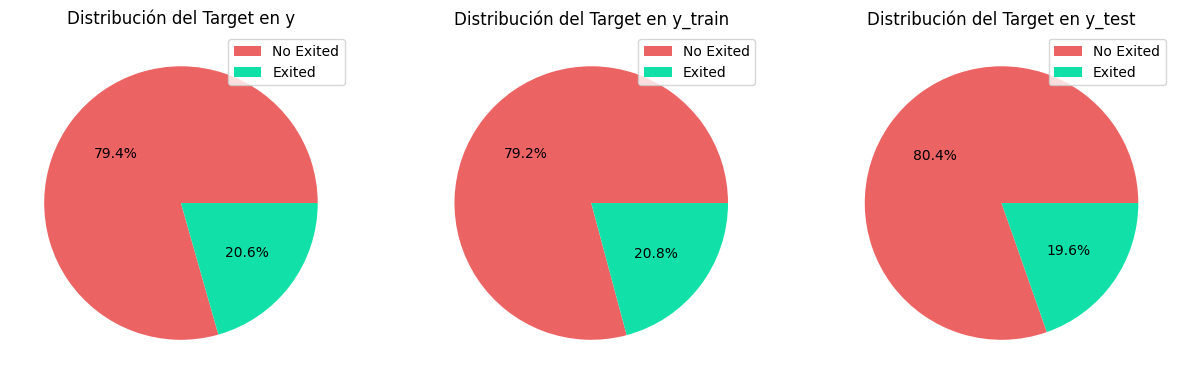

In [7]:
colores = ['#ec6363', '#11e1a8']
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].pie(y.value_counts(), autopct='%1.1f%%', colors=colores)
axes[0].set_title('Distribución del Target en y')
axes[0].legend(['No Exited', 'Exited'], loc='upper right')

axes[1].pie(y_train.value_counts(), autopct='%1.1f%%', colors=colores)
axes[1].set_title('Distribución del Target en y_train')
axes[1].legend(['No Exited', 'Exited'], loc='upper right')

axes[2].pie(y_test.value_counts(), autopct='%1.1f%%', colors=colores)
axes[2].set_title('Distribución del Target en y_test')
axes[2].legend(['No Exited', 'Exited'], loc='upper right');

## 4.2. Abordamos el problema del desbalance de los datos en el target "Exited":

- Aplicamos Submuestreo (Undersampling):
Esta estrategia implica reducir la cantidad de instancias de la clase mayoritaria (en este caso, 0) para igualarla con la cantidad de instancias de la clase minoritaria (en este caso, 1).

In [8]:
rus = RandomUnderSampler(random_state=10)

X_train_resampled, y_train_resampled = rus.fit_resample(X_train, y_train)

,count
Exited,
0,1333
1,1333


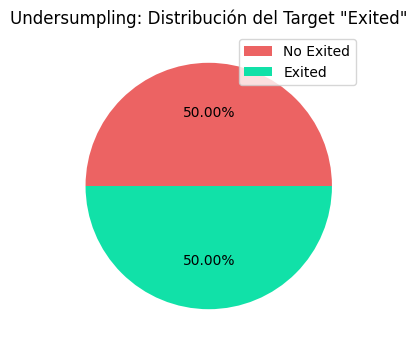

In [9]:
colores = ['#ec6363', '#11e1a8']
plt.figure(figsize=(4,4))
plt.pie(y_train_resampled.value_counts(),
        autopct='%1.2f%%',
        colors=colores)
plt.title('Undersumpling: Distribución del Target "Exited"')
plt.legend(['No Exited', 'Exited'], loc='upper right');

exited_situacion = pd.DataFrame(y_train_resampled.value_counts())
exited_situacion

# 5. Modelos de Machine Learning

1 - Modelos a emplear: 
1. Logistic Regression
2. Random Forest Classifier
3. GradientBoostingClassifier
4. KNeighborsClassifier (KNN)
5. Support Vector Machines (SVM): SVC

2 - Nos centraremos en el scoring de "recall": 
Mide la proporción de instancias positivas correctamente clasificadas entre todas las instancias que realmente son positivas. En este caso, el costo de los falsos negativos es alto y queremos identificar la mayor cantidad posible de casos positivos.


## 5.1. Logistic Regression

In [10]:
reg_log = Pipeline(steps=[
    ("scaler", StandardScaler()),
    ("selectkbest", SelectKBest()),
    ("reglog", LogisticRegression())
])
reg_log_param = {
    'selectkbest__k': np.arange(1, 10), 
    'reglog__C': [0.1, 1, 10]             
}

gs_reg_log = GridSearchCV(reg_log, reg_log_param, cv=10, scoring='recall', verbose=3, n_jobs=-1)

gs_reg_log.fit(X_train_resampled, y_train_resampled)

print("Mejor puntuación de recall:", gs_reg_log.best_score_)
print("Mejores parámetros:", gs_reg_log.best_params_)
print("Mejor estimador (pipeline):", gs_reg_log.best_estimator_)

Fitting 10 folds for each of 27 candidates, totalling 270 fits
Mejor puntuación de recall: 0.757709572438559
Mejores parámetros: {'reglog__C': 0.1, 'selectkbest__k': 3}
Mejor estimador (pipeline): Pipeline(steps=[('scaler', StandardScaler()), ('selectkbest', SelectKBest(k=3)),
                ('reglog', LogisticRegression(C=0.1))])


In [11]:
final_model_reg_log = gs_reg_log.best_estimator_
final_model_reg_log.fit(X_train_resampled, y_train_resampled)
y_pred = final_model_reg_log.predict(X_test)

In [12]:
print("accuracy_score", accuracy_score(y_test, y_pred))
print("precision_score", precision_score(y_test, y_pred))
print("recall_score", recall_score(y_test, y_pred))
print("roc_auc_score", roc_auc_score(y_test, y_pred))
print("confusion_matrix\n", confusion_matrix(y_test, y_pred))

accuracy_score 0.68875
precision_score 0.353968253968254
recall_score 0.7101910828025477
roc_auc_score 0.6968529286485522
confusion_matrix
 [[879 407]
 [ 91 223]]


In [13]:
selectkbest = final_model_reg_log.named_steps['selectkbest']

features_selected = X_train_resampled.columns[selectkbest.get_support()]

print("Características seleccionadas por SelectKBest:", features_selected)

Características seleccionadas por SelectKBest: Index(['NumOfProducts', 'IsActiveMember', 'Age Category'], dtype='object')


## 5.2. Random Forest Classifier

In [14]:
rnf_pipe = Pipeline(steps=[
    ("scaler", StandardScaler()),
    ("selectkbest", SelectKBest()),
    ("classifier", RandomForestClassifier())
])

rnf_param = {
    "selectkbest__k": np.arange(1, 10),
    "classifier__n_estimators": [10, 100, 1000],
    'classifier__max_depth': [3, 5, 7],
    "classifier__max_features": [1, 2, 3]
}

gs_rnf = GridSearchCV(rnf_pipe,
                      rnf_param,
                      cv=10,
                      scoring='recall',
                      verbose=1,
                      n_jobs=-1)

gs_rnf.fit(X_train_resampled, y_train_resampled)

print("Mejor puntuación de recall:", gs_rnf.best_score_)
print("Mejores parámetros:", gs_rnf.best_params_)
print("Mejor estimador (pipeline):", gs_rnf.best_estimator_)

Fitting 10 folds for each of 243 candidates, totalling 2430 fits


Mejor puntuación de recall: 0.7397037369543262
Mejores parámetros: {'classifier__max_depth': 5, 'classifier__max_features': 1, 'classifier__n_estimators': 10, 'selectkbest__k': 3}
Mejor estimador (pipeline): Pipeline(steps=[('scaler', StandardScaler()), ('selectkbest', SelectKBest(k=3)),
                ('classifier',
                 RandomForestClassifier(max_depth=5, max_features=1,
                                        n_estimators=10))])


In [15]:
final_model_rnf = gs_rnf.best_estimator_
final_model_rnf.fit(X_train_resampled, y_train_resampled)
y_pred = final_model_rnf.predict(X_test)

print("accuracy_score", accuracy_score(y_test, y_pred))
print("precision_score", precision_score(y_test, y_pred))
print("recall_score", recall_score(y_test, y_pred))
print("roc_auc_score", roc_auc_score(y_test, y_pred))
print("confusion_matrix\n", confusion_matrix(y_test, y_pred))

accuracy_score 0.715
precision_score 0.37630662020905925
recall_score 0.6878980891719745
roc_auc_score 0.7047577537617259
confusion_matrix
 [[928 358]
 [ 98 216]]


In [16]:
selectkbest = final_model_rnf.named_steps['selectkbest']

features_selected = X_train_resampled.columns[selectkbest.get_support()]

print("Características seleccionadas por SelectKBest:", features_selected)

Características seleccionadas por SelectKBest: Index(['NumOfProducts', 'IsActiveMember', 'Age Category'], dtype='object')


## 5.5. SVC

In [17]:
pipe = Pipeline(steps=[
    ("scaler", StandardScaler()),
    ("selectkbest", SelectKBest()),
    ("classifier", SVC())
])

svm_params = {
    'selectkbest__k':np.arange(5,10),
    'classifier': [SVC()],
    'classifier__C': [0.1,1,10]
}
gs_svc = GridSearchCV(rnf_pipe,
                         svm_params,
                         cv = 4,
                         scoring = 'recall',
                         verbose = 1,
                         n_jobs = -1)

gs_svc.fit(X_train_resampled, y_train_resampled)

print("Mejor puntuación de recall:", gs_svc.best_score_)
print("Mejores parámetros:", gs_svc.best_params_)
print("Mejor estimador (pipeline):", gs_svc.best_estimator_)

Fitting 4 folds for each of 15 candidates, totalling 60 fits


Mejor puntuación de recall: 0.6811804319289348
Mejores parámetros: {'classifier': SVC(), 'classifier__C': 0.1, 'selectkbest__k': 9}
Mejor estimador (pipeline): Pipeline(steps=[('scaler', StandardScaler()), ('selectkbest', SelectKBest(k=9)),
                ('classifier', SVC(C=0.1))])


In [18]:
final_model_svc = gs_svc.best_estimator_
final_model_svc.fit(X_train_resampled, y_train_resampled)
y_pred = final_model_svc.predict(X_test)

print("accuracy_score", accuracy_score(y_test, y_pred))
print("precision_score", precision_score(y_test, y_pred))
print("recall_score", recall_score(y_test, y_pred))
print("roc_auc_score", roc_auc_score(y_test, y_pred))
print("confusion_matrix\n", confusion_matrix(y_test, y_pred))

accuracy_score 0.74875
precision_score 0.4123505976095618
recall_score 0.6592356687898089
roc_auc_score 0.7149211003358065
confusion_matrix
 [[991 295]
 [107 207]]


In [19]:
selectkbest = final_model_svc.named_steps['selectkbest']

features_selected = X_train_resampled.columns[selectkbest.get_support()]

print("Características seleccionadas por SelectKBest:", features_selected)

Características seleccionadas por SelectKBest: Index(['Geography', 'Gender', 'Balance', 'NumOfProducts', 'IsActiveMember',
       'EstimatedSalary', 'Card Type', 'Age Category', 'CreditScore Category'],
      dtype='object')


# 6. Pipeline

In [116]:
pipe = Pipeline(steps=[
    ("scaler", StandardScaler()),
    ("selectkbest", SelectKBest(k=10)),
    ("classifier", RandomForestClassifier())
])

df_pipe = pd.DataFrame(pipe.named_steps.items(), columns=["Step", "Object"])
df_pipe
df_pipe.to_csv("../data_csv/pipeline.csv", index = False)

In [115]:
parametros = {
    'Modelo': ['Logistic Regression', 'Random Forest Classifier', 'GradientBoostingClassifier', 'KNeighborsClassifier', 'Support Vector Machines (SVM)'],
    'Scaler': [StandardScaler(), StandardScaler(), StandardScaler(), StandardScaler(), StandardScaler()],
    'SelectKBest__k': [np.arange(5, 13), np.arange(5, 13), np.arange(5, 13), np.arange(5, 13), np.arange(5, 13)],
    'Classifier': [LogisticRegression(), RandomForestClassifier(), GradientBoostingClassifier(), KNeighborsClassifier(), SVC()],
    'Classifier__C': [None, None, None, None, [0.1, 1, 10, 100]],
    'Classifier__max_depth': [None, [3, 5, 7, 10], [3, 5, 7, 10], None, None],
    'Classifier__n_estimators': [None, [50, 100, 200, 500], [50, 100, 200, 500], None, None],
    'Classifier__n_neighbors': [None, None, None, np.arange(5, 20), None],
    'Classifier__kernel': [None, None, None, None, ['poly']]
}

df_parametros = pd.DataFrame(parametros)
df_parametros.to_csv("../data_csv/parametros.csv", index = False)

In [20]:
pipe = Pipeline(steps=[
    ("scaler", StandardScaler()),
    ("selectkbest", SelectKBest(k=10)),
    ("classifier", RandomForestClassifier())
])

log_params = {
    'scaler': [StandardScaler(), None],
    'selectkbest__k': np.arange(5, 13),
    'classifier': [LogisticRegression()],
    'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100]
}

rf_params = {
    'scaler': [StandardScaler(), None],
    'selectkbest__k': np.arange(5, 13),
    'classifier': [RandomForestClassifier()],
    'classifier__max_depth': [3, 5, 7, 10],
    'classifier__n_estimators': [50, 100, 200, 500]
}

gb_params = {
    'scaler': [StandardScaler(), None],
    'selectkbest__k': np.arange(5, 13),
    'classifier': [GradientBoostingClassifier()],
    'classifier__max_depth': [3, 5, 7, 10],
    'classifier__n_estimators': [50, 100, 200, 500]
}

knn_params = {
    'scaler': [StandardScaler(), None],
    'selectkbest__k': np.arange(5, 13),
    'classifier': [KNeighborsClassifier()],
    'classifier__n_neighbors': np.arange(5, 20)
}

svm_params = {
    'scaler': [StandardScaler(), None],
    'selectkbest__k': np.arange(5, 13),
    'classifier': [SVC()],
    'classifier__C': [0.1, 1, 10, 100],
    'classifier__kernel': ['poly'],
}

search_space = [log_params, rf_params, gb_params, knn_params, svm_params]

#scoring = {'f1_weighted': 'f1_weighted', 'precision_weighted': 'precision_weighted', 'recall_weighted': 'recall_weighted'}

clf_gs = GridSearchCV(estimator=pipe, param_grid=search_space, cv=5, scoring="accuracy", verbose=3, n_jobs=-1) #scoring=scoring, refit='recall_weighted'
clf_gs.fit(X_train_resampled, y_train_resampled)

print("Mejor clasificador:", clf_gs.best_estimator_)
print("Mejor puntuación de recall:", clf_gs.best_score_)
print("Mejores parámetros:", clf_gs.best_params_)

Fitting 5 folds for each of 912 candidates, totalling 4560 fits
Mejor clasificador: Pipeline(steps=[('scaler', StandardScaler()), ('selectkbest', SelectKBest(k=9)),
                ('classifier', RandomForestClassifier(max_depth=5))])
Mejor puntuación de recall: 0.7483124986824631
Mejores parámetros: {'classifier': RandomForestClassifier(), 'classifier__max_depth': 5, 'classifier__n_estimators': 100, 'scaler': StandardScaler(), 'selectkbest__k': 9}


In [127]:
final_model_gs = clf_gs.best_estimator_
final_model_gs.fit(X_train_resampled, y_train_resampled)
y_pred = final_model_gs.predict(X_test)

print("Accuracy Score:", accuracy_score(y_test, y_pred))
print("Precision Score:", precision_score(y_test, y_pred))
print("Recall Score:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

Accuracy Score: 0.77125
Precision Score: 0.43953488372093025
Recall Score: 0.6019108280254777
F1 Score: 0.5080645161290323
ROC AUC Score: 0.7072540143237808
Confusion Matrix:
 [[1045  241]
 [ 125  189]]


In [128]:
best_selectkbest = clf_gs.best_estimator_.named_steps['selectkbest']

selected_features = X_train_resampled.columns[best_selectkbest.get_support()]

print("Características seleccionadas:", selected_features)

Características seleccionadas: Index(['Geography', 'Gender', 'Balance', 'NumOfProducts', 'IsActiveMember',
       'EstimatedSalary', 'Card Type', 'Age Category', 'CreditScore Category'],
      dtype='object')


In [133]:
best_classifier = clf_gs.best_estimator_.named_steps['classifier']
feature_importances = best_classifier.feature_importances_
feature_importances

array([0.07852071, 0.03113118, 0.06930257, 0.20930997, 0.13145181,
       0.03143688, 0.01076768, 0.42644203, 0.01163718])

In [139]:
feature_importance_df = pd.DataFrame({'Feature': selected_features, 'Importance': feature_importances})

feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
feature_importance_df.to_csv("../data_csv/features_importance.csv", index = False)
feature_importance_df

,Feature,Importance
7,Age Category,0.426442
3,NumOfProducts,0.209310
4,IsActiveMember,0.131452
0,Geography,0.078521
2,Balance,0.069303
5,EstimatedSalary,0.031437
1,Gender,0.031131
8,CreditScore Category,0.011637
6,Card Type,0.010768


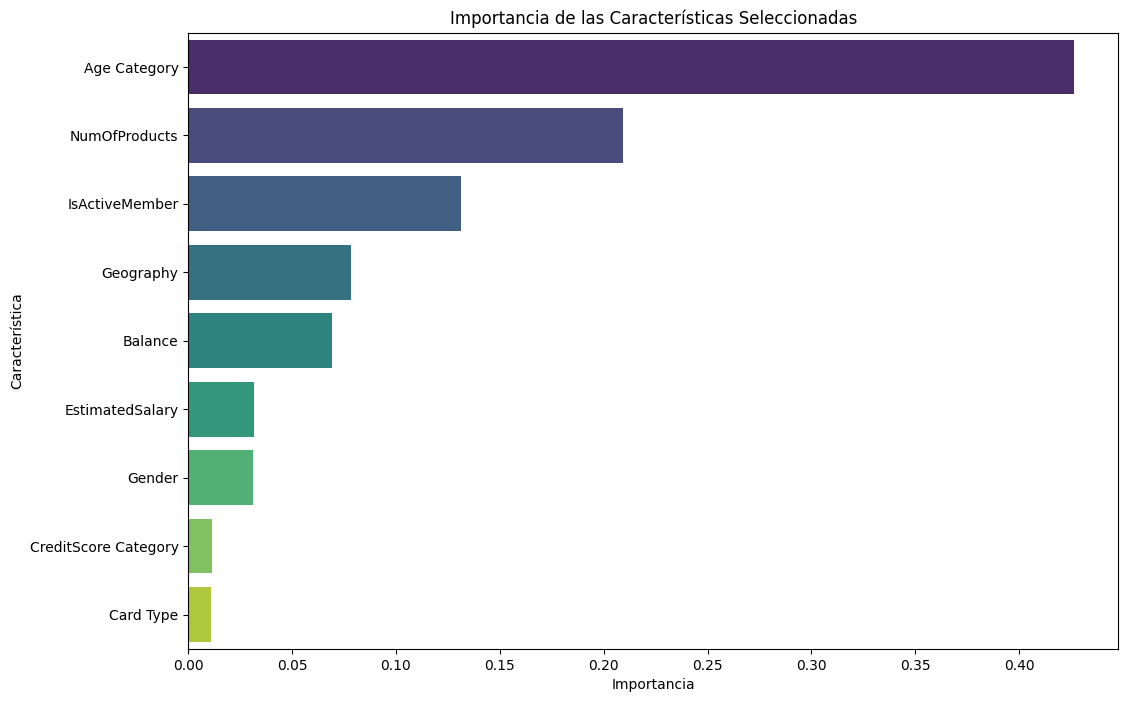

In [138]:
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis')
plt.title('Importancia de las Características Seleccionadas')
plt.xlabel('Importancia')
plt.ylabel('Característica');

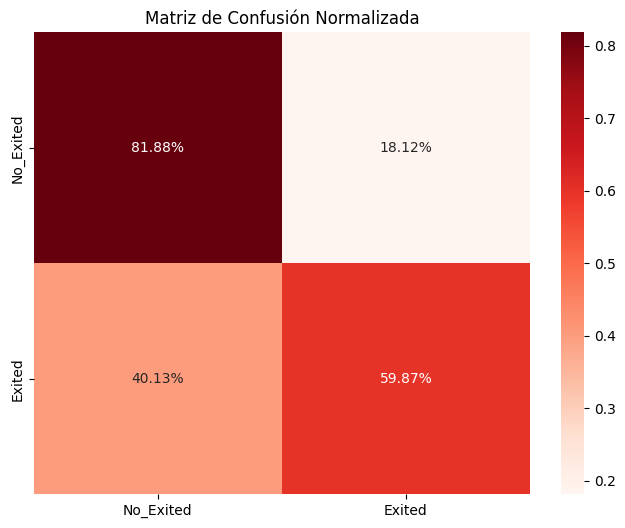

In [26]:
conf_matrix_test = confusion_matrix(y_test, y_pred, normalize='true')

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_test, annot=True, fmt=".2%", cmap='Reds', xticklabels=['No_Exited', 'Exited'], yticklabels=['No_Exited', 'Exited'])
plt.title('Matriz de Confusión Normalizada');

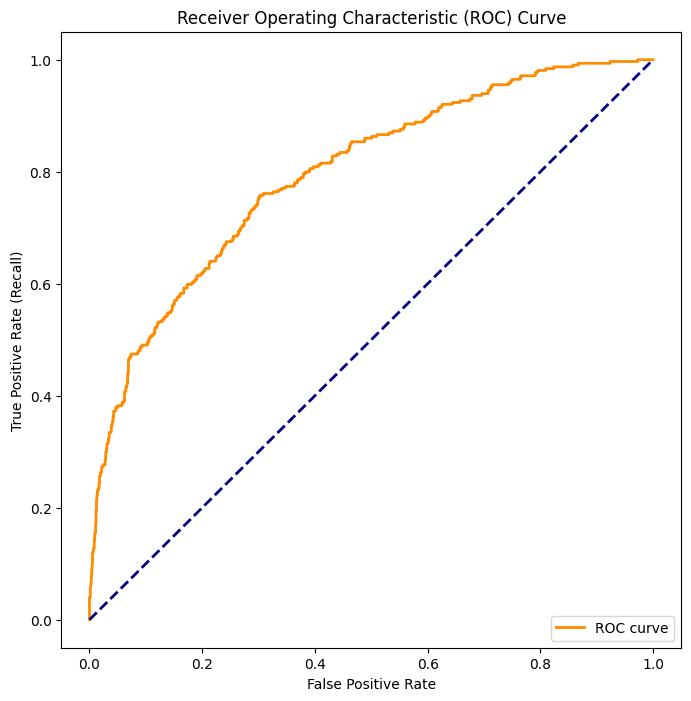

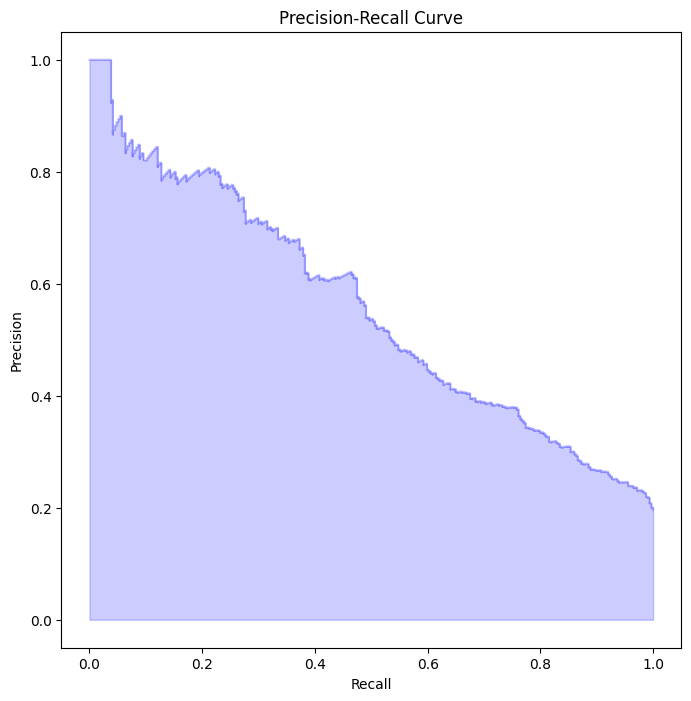

In [27]:
y_pred = clf_gs.predict(X_test)
y_proba = clf_gs.predict_proba(X_test)[:, 1]  

fpr, tpr, thresholds = roc_curve(y_test, y_proba)
precision, recall, _ = precision_recall_curve(y_test, y_proba)


plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

plt.figure(figsize=(8, 8))
plt.step(recall, precision, color='b', alpha=0.2, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

# 7. Evualuación en Test

In [28]:
df_test = pd.read_csv("../data_processed/Test_Churn_processed.csv")
df_test.head()

,Geography,Gender,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Satisfaction Score,Card Type,Point Earned,Age Category,CreditScore Category,Exited
0,2,0,8,102603.30,0,1,1,180693.61,3,1,751,2,3,0
1,1,0,9,0.00,0,1,0,126475.79,2,2,947,1,3,0
2,1,0,1,0.00,0,0,0,133535.99,2,1,930,2,2,0
3,1,0,6,105000.85,0,1,1,87412.24,3,0,281,3,2,1
4,0,0,5,0.00,0,1,1,164886.64,4,0,537,2,2,0


In [29]:
X_t = df_test.drop(columns=["Exited"])
y_t = df_test["Exited"]

In [30]:
y_pred_test = final_model_gs.predict(X_t)
y_pred_test

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [31]:
X_t.shape

(2000, 13)

In [32]:
y_t.shape

(2000,)

In [33]:
print("Accuracy Score:", accuracy_score(y_t, y_pred_test))
print("Precision Score:", precision_score(y_t, y_pred_test))
print("Recall Score:", recall_score(y_t, y_pred_test)), 
print("F1 Score:", f1_score(y_t, y_pred_test)),
print("ROC AUC Score:", roc_auc_score(y_t, y_pred_test))
print("Confusion Matrix:\n", confusion_matrix(y_t, y_pred_test))

Accuracy Score: 0.783
Precision Score: 0.4606946983546618
Recall Score: 0.6445012787723785
F1 Score: 0.5373134328358209
ROC AUC Score: 0.7305787935191911
Confusion Matrix:
 [[1314  295]
 [ 139  252]]


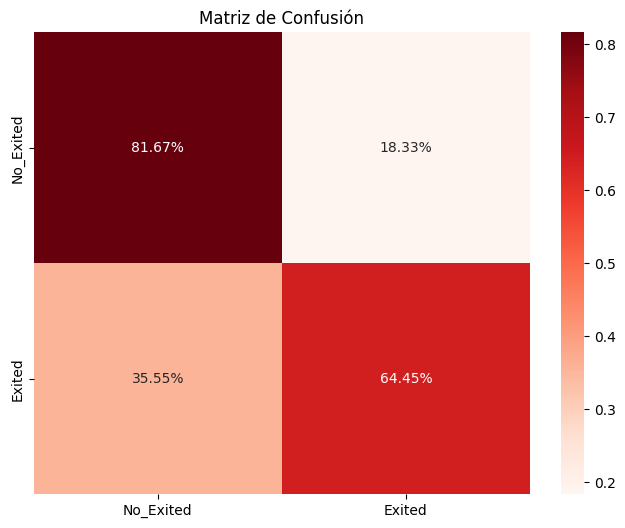

In [34]:
conf_matrix_test = confusion_matrix(y_t, y_pred_test, normalize='true')

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_test, annot=True, fmt=".2%", cmap='Reds', xticklabels=['No_Exited', 'Exited'], yticklabels=['No_Exited', 'Exited'])
plt.title('Matriz de Confusión');

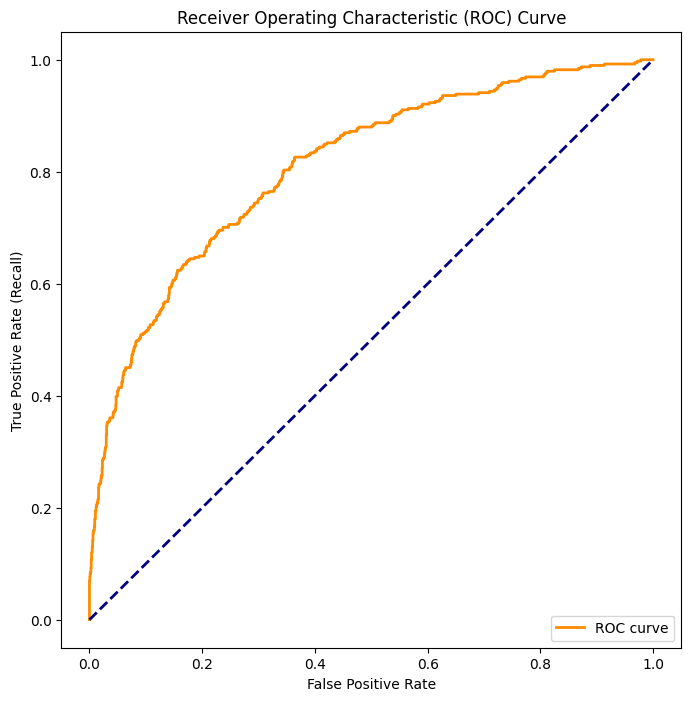

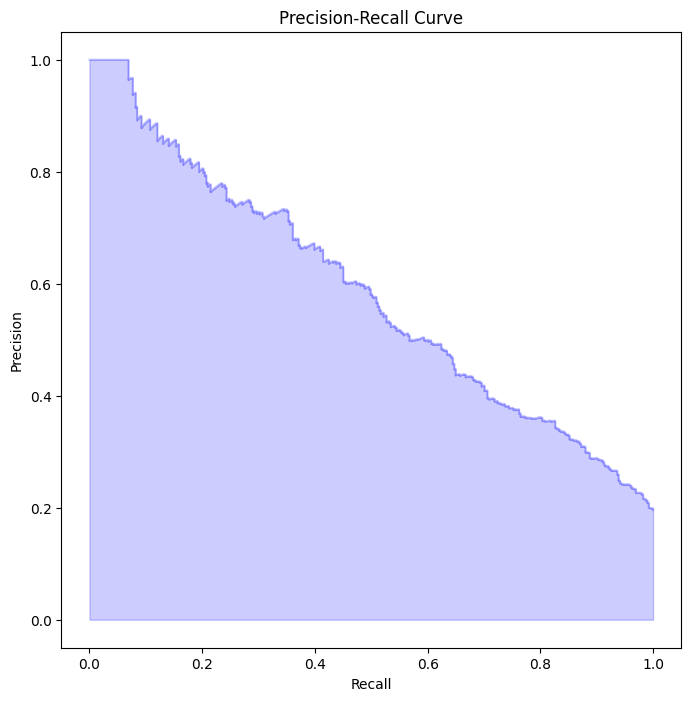

In [35]:
y_pred = clf_gs.predict(X_t)
y_proba = clf_gs.predict_proba(X_t)[:, 1] 

fpr, tpr, thresholds = roc_curve(y_t, y_proba)
precision, recall, _ = precision_recall_curve(y_t, y_proba)


plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

plt.figure(figsize=(8, 8))
plt.step(recall, precision, color='b', alpha=0.2, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

Guardamos el modelo:

In [36]:
filename = '../models/finished_model_gs'

with open(filename, 'wb') as archivo_salida:
    pickle.dump(final_model_gs, archivo_salida)

In [55]:
model_info = {'classifier': RandomForestClassifier(), 'classifier__max_depth': 5, 'classifier__n_estimators': 100, 'scaler': StandardScaler(), 'selectkbest__k': 9}

with open('../models/final_model_gs.yaml', 'w') as yaml_file:
    yaml.dump(model_info, yaml_file)

In [38]:
with open(filename, 'rb') as archivo_entrada:
    modelo_importado_1 = pickle.load(archivo_entrada)

In [39]:
modelo_importado_1

Pipeline(steps=[('scaler', StandardScaler()), ('selectkbest', SelectKBest(k=9)),
                ('classifier', RandomForestClassifier(max_depth=5))])

In [40]:
modelo_importado_1.predict(X_t)

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

Prueba de nuevos valores:

In [108]:
np.random.seed(11)

nuevos_valores = {
    'Geography': np.random.randint(0, 3, size=5),  
    'Gender': np.random.randint(0, 2, size=5),    
    'Tenure': np.random.randint(1, 11, size=5),     
    'Balance': np.random.uniform(0, 150000, size=5), 
    'NumOfProducts': np.random.randint(0, 2, size=5),  
    'HasCrCard': np.random.randint(0, 2, size=5),   
    'IsActiveMember': np.random.randint(0, 2, size=5), 
    'EstimatedSalary': np.random.uniform(0, 200000, size=5),  
    'Satisfaction Score': np.random.randint(1, 5, size=5), 
    'Card Type': np.random.randint(0, 4, size=5),    
    'Point Earned': np.random.randint(119, 1000, size=5),  
    'Age Category': np.random.randint(0, 5, size=5), 
    'CreditScore Category': np.random.randint(0, 5, size=5)  
}

nuevos_df = pd.DataFrame(nuevos_valores)
nuevos_df



,Geography,Gender,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Satisfaction Score,Card Type,Point Earned,Age Category,CreditScore Category
0,1,1,1,134085.625543,1,0,1,172800.846523,1,1,120,0,2
1,0,1,1,128573.137061,0,1,0,31028.976608,4,3,250,2,3
2,1,0,5,24762.992639,1,1,1,154966.122805,1,2,846,0,1
3,1,0,3,94850.102074,0,0,1,96621.246719,4,3,584,3,3
4,0,1,2,3072.541919,0,1,0,156661.841988,2,3,699,1,2


In [109]:
modelo_importado_1.predict(nuevos_df)

array([1, 0, 1, 1, 0], dtype=int64)

# 8. No Supervisado

1 - Modelos a emplear: 
1. Principal Component Analysis (PCA): no supervisado
2. Random Forest Classifier
3. GradientBoostingClassifier
4. KNeighborsClassifier (KNN)
5. Support Vector Machines (SVM): SVC

In [44]:
pipe = Pipeline(steps=[
    ("scaler", StandardScaler()),
    ("pca", PCA()),
    ("classifier", RandomForestClassifier())
])

# log_params = {
#     'scaler': [StandardScaler(), None],
#     'classifier': [LogisticRegression()],
#     'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100]
# }

rf_params = {
    'scaler': [StandardScaler(), None],
    'pca__n_components': [5, 10],
    'classifier': [RandomForestClassifier()],
    'classifier__max_depth': [3, 5, 7, 10],
    'classifier__n_estimators': [50, 100, 200, 500]
}

gb_params = {
    'scaler': [StandardScaler(), None],
    'pca__n_components': [5, 10],
    'classifier': [GradientBoostingClassifier()],
    'classifier__max_depth': [3, 5, 7, 10],
    'classifier__n_estimators': [50, 100, 200, 500]
}

knn_params = {
    'scaler': [StandardScaler(), None],
    'pca__n_components': [5, 10],
    'classifier': [KNeighborsClassifier()],
    'classifier__n_neighbors': np.arange(5, 20)
}

svm_params = {
    'scaler': [StandardScaler(), None],
    'pca__n_components': [5, 10],
    'classifier': [SVC()],
    'classifier__C': [0.1, 1, 10, 100],
    'classifier__kernel': ['poly'],
}

search_space = [rf_params, gb_params, knn_params, svm_params]


clf_gs_pca = GridSearchCV(estimator=pipe, param_grid=search_space, cv=5, verbose=3, n_jobs=-1)
clf_gs_pca.fit(X_train_resampled, y_train_resampled)

print("Mejor clasificador:", clf_gs_pca.best_estimator_)
print("Mejor puntuación de recall:", clf_gs_pca.best_score_)
print("Mejores parámetros:", clf_gs_pca.best_params_)

Fitting 5 folds for each of 204 candidates, totalling 1020 fits
Mejor clasificador: Pipeline(steps=[('scaler', None), ('pca', PCA(n_components=10)),
                ('classifier',
                 RandomForestClassifier(max_depth=7, n_estimators=50))])
Mejor puntuación de recall: 0.7123040383385683
Mejores parámetros: {'classifier': RandomForestClassifier(), 'classifier__max_depth': 7, 'classifier__n_estimators': 50, 'pca__n_components': 10, 'scaler': None}


In [45]:
final_model_gs_pca = clf_gs_pca.best_estimator_
final_model_gs_pca.fit(X_train_resampled, y_train_resampled)
y_pred = final_model_gs_pca.predict(X_test)

print("Accuracy Score:", accuracy_score(y_test, y_pred))
print("Precision Score:", precision_score(y_test, y_pred))
print("Recall Score:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

Accuracy Score: 0.715625
Precision Score: 0.37566137566137564
Recall Score: 0.678343949044586
F1 Score: 0.4835414301929626
ROC AUC Score: 0.7015358936513754
Confusion Matrix:
 [[932 354]
 [101 213]]


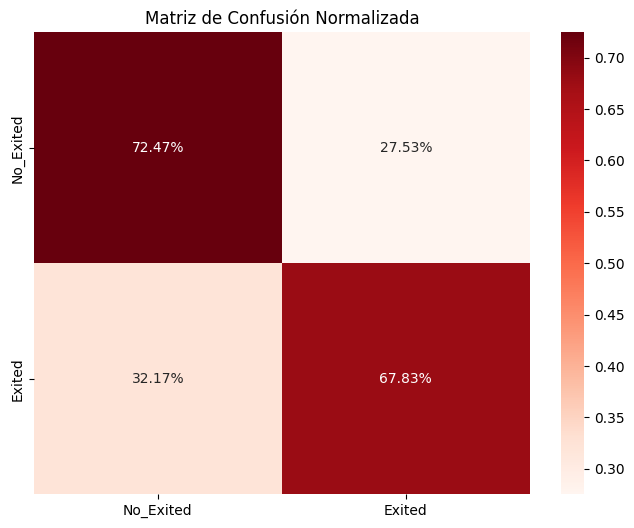

In [46]:
conf_matrix_test = confusion_matrix(y_test, y_pred, normalize='true')

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_test, annot=True, fmt=".2%", cmap='Reds', xticklabels=['No_Exited', 'Exited'], yticklabels=['No_Exited', 'Exited'])
plt.title('Matriz de Confusión Normalizada');

In [47]:
y_pred_test = final_model_gs_pca.predict(X_t)
y_pred_test

array([1, 0, 0, ..., 0, 0, 0], dtype=int64)

In [48]:
print("Accuracy Score:", accuracy_score(y_t, y_pred_test))
print("Precision Score:", precision_score(y_t, y_pred_test, average='weighted'))
print("Recall Score:", recall_score(y_t, y_pred_test, average='weighted'))
print("F1 Score:", f1_score(y_t, y_pred_test, average='weighted'))
print("ROC AUC Score:", roc_auc_score(y_t, y_pred_test))
print("Confusion Matrix:\n", confusion_matrix(y_t, y_pred_test))

Accuracy Score: 0.7265
Precision Score: 0.7984354112894176
Recall Score: 0.7265
F1 Score: 0.7494779963563235
ROC AUC Score: 0.7003039170649751
Confusion Matrix:
 [[1196  413]
 [ 134  257]]


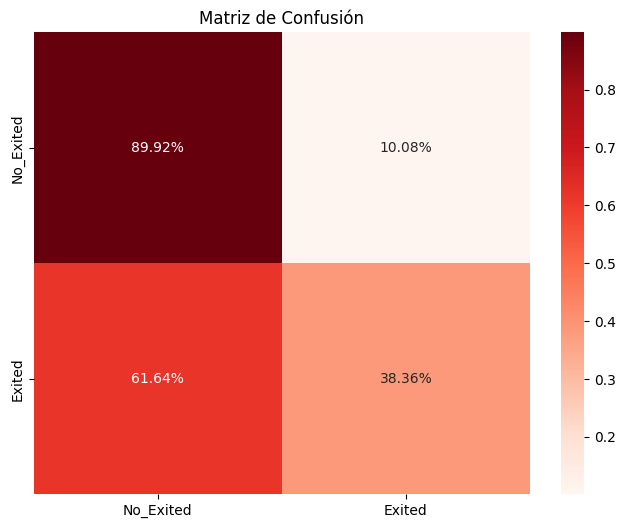

In [49]:
conf_matrix_test = confusion_matrix(y_pred_test, y_t, normalize='true')

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_test, annot=True, fmt=".2%", cmap='Reds', xticklabels=['No_Exited', 'Exited'], yticklabels=['No_Exited', 'Exited'])
plt.title('Matriz de Confusión');

In [50]:
filename = '../models/finished_model_gs_pca'

with open(filename, 'wb') as archivo_salida:
    pickle.dump(final_model_gs, archivo_salida)

In [56]:
model_info = {'classifier': RandomForestClassifier(), 'classifier__max_depth': 7, 'classifier__n_estimators': 50, 'pca__n_components': 10, 'scaler': None}

with open('../models/final_model_gs_pca.yaml', 'w') as yaml_file:
    yaml.dump(model_info, yaml_file)

In [52]:
with open(filename, 'rb') as archivo_entrada:
    modelo_importado_2 = pickle.load(archivo_entrada)

In [105]:
np.random.seed(12)

nuevos_valores = {
    'Geography': np.random.randint(0, 3, size=5),  
    'Gender': np.random.randint(0, 2, size=5),    
    'Tenure': np.random.randint(0, 11, size=5),     
    'Balance': np.random.uniform(0, 150000, size=5), 
    'NumOfProducts': np.random.randint(0, 2, size=5),  
    'HasCrCard': np.random.randint(0, 2, size=5),   
    'IsActiveMember': np.random.randint(0, 2, size=5), 
    'EstimatedSalary': np.random.uniform(0, 200000, size=5),  
    'Satisfaction Score': np.random.randint(1, 5, size=5), 
    'Card Type': np.random.randint(0, 4, size=5),    
    'Point Earned': np.random.randint(119, 1000, size=5),  
    'Age Category': np.random.randint(0, 5, size=5), 
    'CreditScore Category': np.random.randint(0, 5, size=5)  
}

nuevos_df = pd.DataFrame(nuevos_valores)
nuevos_df


,Geography,Gender,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Satisfaction Score,Card Type,Point Earned,Age Category,CreditScore Category
0,2,0,9,101399.637318,1,0,0,23254.603480,2,0,322,3,3
1,1,0,2,147547.073972,0,0,1,61979.516898,3,0,364,3,2
2,1,1,6,72229.531615,1,0,1,134290.529042,2,1,490,4,4
3,2,0,10,136880.825090,1,0,1,94245.955650,1,3,955,0,2
4,0,1,0,28481.451632,0,0,1,163233.659609,1,0,812,2,2


In [107]:
modelo_importado_2.predict(nuevos_df)

array([1, 1, 1, 1, 0], dtype=int64)